<a href="https://colab.research.google.com/github/NID123-CH/NLP--Hugging-Face-Project/blob/main/DSR_40_Language_Generation_with_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [2]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (74/74), 1.12 MiB | 4.94 MiB/s, done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'lovec

# Data

In [3]:
batch_size = 32 # Not for SGD!
seed = 42

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

dataset_original_all   = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files.
Found 16 files.
Found 4 files.


In [4]:
for x in dataset_original_all.take(1):
    print(x.shape)
    print(x[0])

(20,)
tf.Tensor(b'the thing on the doorstep\n\ni\n\nit is true that i have sent six bullets through the head of my best friend , and yet i hope to show by this statement that i am not his murderer . at first i shall be called a madman--madder than the man i shot in his cell at the arkham sanitarium . later some of my readers will weigh each statement , correlate it with the known facts , and ask themselves how i could have believed otherwise than i did after facing the evidence of that horror--that thing on the doorstep .\n\nuntil then i also saw nothing but madness in the wild tales i have acted on . even now i ask myself whether i was misled--or whether i am not mad after all . i do not know--but others have strange things to tell of edward and asenath derby , and even the stolid police are at their wits\' ends to account for that last terrible visit . they have tried weakly to concoct a theory of a ghastly jest or warning by discharged servants , yet they know in their hearts that t

# Create the text vectorizer.

In [5]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
print(vocabulary)

['', '[UNK]', 'the', ',', '.', 'and', 'of', 'to', 'a', 'in', 'was', 'i', 'that', 'had', 'it', 'he', 'as', 'with', 'at', 'on', 'but', 'for', 'not', 'from', 'were', ';', 'his', 'which', 'my', 'we', 'they', 'all', 'by', 'be', 'there', 'this', 'could', 'or', 'have', 'me', 'one', 'been', 'when', 'some', 'no', 'old', 'would', 'an', 'what', 'their', 'him', 'so', 'about', 'out', 'our', 'more', 'its', 'up', 'seemed', 'did', 'now', 'only', 'them', 'into', 'is', 'very', 'like', 'than', 'though', "an'", 'before', 'even', 'must', 'those', 'any', 'saw', 'then', 'other', 'things', 'through', 'after', 'time', 'over', 'down', 'who', 'where', '?', 'made', 'found', 'came', 'if', 'great', 'these', 'place', 'never', 'such', 'us', 'might', 'whose', 'much', 'certain', 'thing', 'man', 'night', 'most', 'back', 'thought', 'strange', 'come', 'beyond', 'upon', 'almost', 'many', 'men', 'two', 'seen', 'long', 'too', 'yet', 'her', 'still', 'she', 'once', 'left', 'first', 'see', 'heard', 'off', 'do', 'years', 'black'

# Create dataset for autoregression.

In [7]:
sequence_length = 32
padding_token_id = 0

def create_dataset_for_autoregression(dataset, hop_length=1):
    x_inputs = []
    y_outputs = []

    for books in dataset:

        books = encoder(books).numpy() # Encodes all books into word indices.

        for book in tqdm(books):

            # Remove the padding tokens.
            book = [index for index in list(book) if index != padding_token_id]

            for start_index in range(0, len(book) - sequence_length, hop_length):
                x = book[start_index:start_index + sequence_length]
                y = book[start_index + 1: start_index + sequence_length + 1]
                assert len(x) == sequence_length
                assert len(y) == sequence_length

                x_inputs += [x]
                y_outputs += [y]

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 4/4 [00:00<00:00, 267.49it/s]


In [8]:
def decode(indices):
    return " ".join([vocabulary[index] for index in indices])

for input, output in dataset_train.take(8):
    print("in: ", decode(input))
    print("out:", decode(output))
    print("")

in:  the street men of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was
out: street men of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was but

in:  street men of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was but
out: men of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was but a

in:  men of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was but a
out: of strength and honour fashioned that street : good valiant men of our blood who had come from the blessed isles across the sea . at first it was but a path

in:  of strengt

In [9]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

## Train the model

In [10]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size)) # Like is!
#model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))

model.add(layers.Dropout(0.1)) # Plot twist!
model.add(layers.LSTM(embedding_size, return_sequences=True)) # Plot twist!
model.add(layers.Dropout(0.1)) # Plot twist!
model.add(layers.Dense(vocabulary_size, activation="softmax"))
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # Important! Computing the error between a predicted prob-dist and the label.
    metrics=["accuracy"]
)

#model.fit(
#    dataset_train.shuffle(10_000).batch(256),
#    epochs=10, # TODO go up to 10
#    validation_data=dataset_valid.batch(256)
#)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model.summary()

#render_history(model.history)

In [11]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)
    print(seed_text)

    input_sequence = encoder(seed_text).numpy().tolist()
    print(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        if len(sequence) > sequence_length:
            sequence = input_sequence[-sequence_length:]
        assert len(sequence == sequence_length)
        prediction = model.predict(np.expand_dims(sequence, axis=0), verbose=False)
        #print(prediction.shape)
        #plt.plot(prediction[0][-1])
        #assert False
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        print(predicted_index)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


#generate(model, "The Shadow out of time", 100, temperature=1.0)

In [15]:
def create_transformer(layers_number=4, num_heads=4):

  #Start with input embedding

  inputs=tf.keras.Input(shape=(sequence_length,), dtype =tf.int32)
  embedding = layers.Embedding(input_dim =vocabulary_size, output_dim =embedding_size)(inputs)

  #Add positional eNCODING

  positions =tf.range(start=0, limit=sequence_length, delta=1)
  positional_embedding = layers.Embedding(input_dim =sequence_length, output_dim =embedding_size)(positions)
  embedding += positional_embedding #

  #Create decoders(For each decoder add layer normalization)
  for _ in range(layers_number):

    x1 =layers.LayerNormalization(epsilon=1e-6)(embedding)

    #Do attention
    attention_output =layers.MultiHeadAttention(num_heads=3, key_dim=embedding_size, dropout=0.1)(x1, x1, use_causal_mask =True) #(x1=query, x1=key, mask)

    #Skip Connection
    x2 =layers.Add()([attention_output, embedding])

    #Normalise
    x3 =layers.LayerNormalization(epsilon=1e-6)(x2)

    #MLP
    x4 =layers.Dense(embedding_size*2, activation="gelu")(x3)
    x4 =layers.Dense(embedding_size, activation="gelu")(x4) # Change this line to have output dimension of embedding_size

    #Skip connection
    embedding = x4 + x2 #Now the shapes should match for addition

    #Head
    #outputs =layers.Dense(vocabulary_size, activation="softmax")(embedding) # This is incorrect placing of the head. You don't want to predict every step

  outputs =layers.Dense(vocabulary_size, activation="softmax")(embedding) # Place it outside the loop


  #Return the model
  model =models.Model(inputs =inputs, outputs=outputs)
  return model

model= create_transformer()
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # Important! Computing the error between a predicted prob-dist and the label.
    metrics=["accuracy"]
)

model.fit(
    dataset_train.shuffle(10_000).batch(256),
   epochs=10, # TODO go up to 10
  validation_data=dataset_valid.batch(256)
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 32, 128)        │      1,280,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 128)        │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 32, 128)        │            256 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 32, 128)        │        197,888 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 32, 128)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 32, 128)        │            256 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32, 256)        │         33,024 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32, 128)        │         32,896 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 32, 128)        │              0 │ dense_4[0][0],         │
│                           │                        │                │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 32, 128)        │            256 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 32, 128)        │        197,888 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 32, 128)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 32, 128)        │            256 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)      

 Total params: 3,627,280 (13.84 MB)

 Trainable params: 3,627,280 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.1695 - loss: 5.2208 - val_accuracy: 0.1057 - val_loss: 8.3525
Epoch 2/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.3423 - loss: 3.5828 - val_accuracy: 0.0943 - val_loss: 9.3885
Epoch 3/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.4828 - loss: 2.5125 - val_accuracy: 0.0969 - val_loss: 10.2605
Epoch 4/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.5827 - loss: 1.9156 - val_accuracy: 0.0915 - val_loss: 10.9754
Epoch 5/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.6515 - loss: 1.5522 - val_accuracy: 0.0932 - val_loss: 11.6139
Epoch 6/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7005 - loss: 1.3104 - val_accuracy: 0.0932 - val_loss: 12.0615
Epoch 7/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7343 - loss: 1.1498 - val_accuracy: 0.0929 - val_loss: 12.5346
Epoch 8/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7601 - loss: 1.03

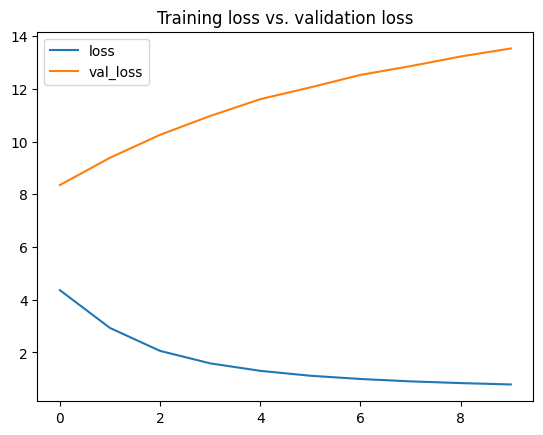

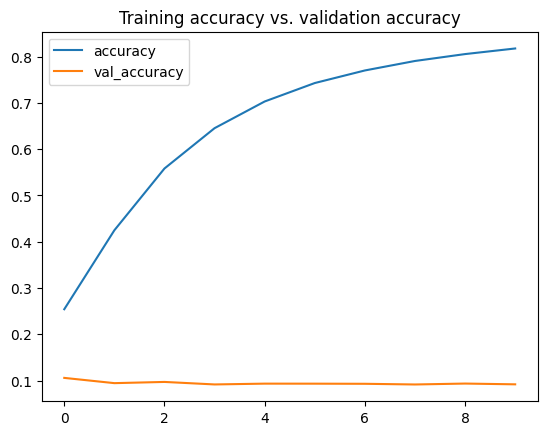

In [18]:
render_history(model.history)

In [ ]:
# TODO: Implement Transformer!

In [22]:
def generate(model, seed_text, generated_sequence_length, temperature):
    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)


    input_sequence = encoder(seed_text).numpy().tolist()

    # Pad the input_sequence if it's shorter than sequence_length
    if len(input_sequence) < sequence_length:
        input_sequence = [0] * (sequence_length - len(input_sequence)) + input_sequence

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        sequence = input_sequence[-sequence_length:]
        assert len(sequence) == sequence_length

        prediction = model.predict(np.expand_dims(sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)

        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    text =text.replace(" ", " ")
    print(text)
    print("")

In [23]:
generate(model, "The Shadow out of time", 100, temperature=1.0)

                           the shadow out of time, and behind the aged cat, and started when the three professors from the arkham had heard. the hushed lighted by the shadowed farm-house, and and as a things all the things were very thick on the ground gets to track all vacant space. yet the archaic houses, as i have said, there is elsewhere. no good. it had expected

